In [ ]:
# path to your test data
DATA = '/data/solafune/eval'
# path to your model checkpoint
CKPT = '/data/solafune/ckpt1'

import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

In [1]:
from data import infer_collate, InferSet

infer_set = InferSet(DATA)

/home/yukai/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yukai/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Load model

In [2]:
from model import PepperNet

mod = PepperNet.load_from_checkpoint(CKPT)
mod.eval()
mod = mod.to(DEVICE)

Loaded encoder weights from /home/yukai/project/solafune/Prithvi_100M/Prithvi_100M.pt


PepperNet(
  (backbone): MAEEncoder(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(6, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2):

## Inference

In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

infer_loader = DataLoader(infer_set, batch_size=32, shuffle=False, collate_fn=infer_collate)

preds = []

for batch in tqdm(infer_loader):
    with torch.no_grad():
        input = batch['image'].to(DEVICE)
        pred = mod(input)
        pred = F.softmax(pred, dim=1)
        prob_pos = pred[:, 1].cpu().numpy()
        preds.extend(prob_pos)

100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


/home/yukai/miniconda3/envs/dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

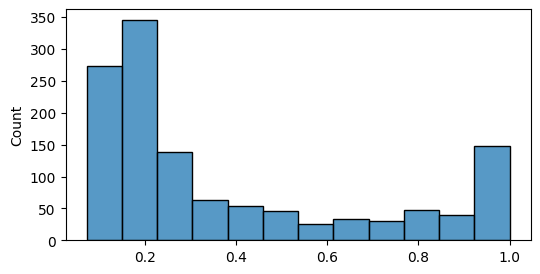

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,3))
sns.histplot(preds)

In [5]:
import numpy as np
THRERSHOLD = 0.6
np.sum(np.array(preds) > THRERSHOLD)

305

In [11]:
files = [x.name for x in infer_set.imgs]
preds_label = [1 if p > THRERSHOLD else 0 for p in preds]

In [12]:
import pandas as pd
df = pd.DataFrame({'file_name': files, 'pred': preds_label})
df.to_csv('upload.csv', index=False, header=False)